In [1]:
from astropy import units as u
from astropy import coordinates as coord
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table
from time import process_time

import astroquery
from astroquery.simbad import Simbad
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import splat

Adding 145 sources from C:\splat-master/resources/Data/Public/LRIS-RED/ to spectral database


# Preparing the Data

## Functions

In [2]:
def prep_data(path):
    df = pd.read_excel(path)
    df['COORD'] = df['NAME'].apply(lambda x: x.split('I')[1])
    # kast.to_excel('kast_stage1.xlsx', index=False)
    df['COORD'] = df['COORD'].apply(lambda x: x[0:2] + ':' + x[2:4] + '.' + x[4] + ' ' + x[5:8] + ':' + x[8:10]) # Reformat of the coordinates into "hh:mm:ss +hh:mm:ss"
    df['ra'] = df['COORD'].apply(lambda x: coord.SkyCoord(x, unit=(u.hourangle, u.deg)).to_string('decimal').split(' ')[0]) # Setting up 'ra' and 'dec' columns (deg)
    df['dec'] = df['COORD'].apply(lambda x: coord.SkyCoord(x, unit=(u.hourangle, u.deg)).to_string('decimal').split(' ')[1])
    df['SKYCOORD'] = df['COORD'].apply(lambda x: coord.SkyCoord(x, unit=(u.hourangle, u.deg))) # "SKYCOORD" stores astropy SkyCoord objects for convenience
    return df

## Working Area

In [3]:
kast = prep_data('./kast_stage0.xlsx')
kast['LSPN_SPT'] = kast['CLASS'] + kast['SUBTYPE'].astype('str')

# Customize the SIMBAD

## Functions

In [4]:
def my_simbad(path):
    fields_to_add = pd.read_excel(path) # read in the fields we want from the excel sheet
    fields_to_add = fields_to_add.where(fields_to_add['output name'] != '[drop]').dropna(how='all') # drop the unwanted fields

    fields_to_add['input name'] = fields_to_add['input name'].apply(lambda x: x[:-2] + '(' + x[-1] + ')' if 'FLUX' in x else x) # reformat from "FLUX_U" to "FLUX(U)"
    fields_to_add['input name'] = fields_to_add['input name'].apply(lambda x: x.split('(')[0].lower() + '(' + x.split('(')[1]  if '(' in x else x) # reformat from "FLUX(U)" to "flux(U)" This way we preserve the captial and lower cases inside the parentheses
    fields_to_add['input name'] = fields_to_add['input name'].apply(lambda x: x if '(' in x else x.lower()) # reformat: convert all others to lower cases.

    fields_to_add['input name'] = fields_to_add['input name'].replace({'plx_value':'plx', 'mk_spectral_type':'mk', 'sp_type':'sptype'}) # reformat some other fields

    fields_to_add.drop(index=0, axis=1, inplace=True) # drop the row 'main_id' to avoid repeated fields. 'main_id' is already included as default.

    fields_to_add.reset_index(inplace=True) # reset index which was messed up when we drop the unwanted fields.
    fields_to_add.drop(columns='index', axis=0, inplace=True)

    fields_list = list(fields_to_add['input name']) # create a list to add to the search fields
    fields_list.append('otype')
    
    customSimbad = Simbad()
    
    for item in fields_list:
        try:
            customSimbad.add_votable_fields(item)
        except:
            continue
    
    print('"customSimbad" is ready')
    return customSimbad
    

## Working Area

In [5]:
customSimbad = my_simbad('./Catalogs and columns.xlsx')

"customSimbad" is ready


In [18]:
# WIP

In [23]:
c = splat.properCoordinates('00:02.0 +41:04')
c = coord.SkyCoord(c.ra + 0.75*u.arcmin, c.dec + 30*u.arcsec)
c.to_string('hmsdms')

'00h02m03s +41d04m30s'

In [55]:
def adjust_coord(c):
    if '+' in c.to_string('hmsdms'):
        result = coord.SkyCoord(c.ra + 0.75*u.arcmin, c.dec + 30*u.arcsec)
    
    

TypeError: Can only get separation to another SkyCoord or a coordinate frame with data

In [10]:
from astroquery.vizier import Vizier
from astropy.coordinates import Angle

In [20]:
v = Vizier(columns=["*", "+_r"], catalog="II/246")
result = v.query_region(c, radius=Angle(1.5, "arcmin"))
result['II/246/out']

In [7]:
# WIP

# Query

## Functions

In [6]:
unwanted_otypes = ['X','QSO', 'Galaxy', 'Blue', 'Radio', 'WD*', 'SN', 'Candidate_RGB*', 'Planet', 'Planet?', 'GroupG', 'Unknown', 'RadioG', 'GinCl','BClG', 'Compact_Gr_G','ClG', 'LINER', 'Seyfert_1','AGN', 'EmG', 'GinGroup', 'V*', 
                   'Inexistent', 'Radio(mm)', 'S*', 'HB*', 'Seyfert_2', 'MolCld', 'DkNeb', 'gammaBurst', 'RGB*', 'UV', 'C*', 'YSO', 'GiC','IR>30um']

unwanted_spt = ['IV', 'III', 'II', 'G', 'F', 'A', 'B', 'O']

favorite_otypes = ['low-mass*', 'BYDra', 'brownD*', 'PM*', 'BY*', 'Fl*', 'Flare*', 'SB*', 'Ro*','LM*', 'RotV*','Candidate_brownD*','Candidate_Hsd','Er*']

bibcode_list = ['2013AJ....145..102L', '2007ApJ...669.1235L', '2020AJ....159...30H']

def o_filter(df,extra=[],olist=unwanted_otypes):
    if len(extra) ==0:
        result = df.drop(index = df[df['OTYPE'].str.decode('ascii').isin(olist)].index)
        return result
    else:
        olist.extend(extra)
        result = df.drop(index = df[df['OTYPE'].str.decode('ascii').isin(olist)].index)
        return result

def s_filter(df):
    result = df.drop(index = df[df['SP_TYPE'].str.decode('ascii').apply(lambda x: 'y' if any(ele in x for ele in unwanted_spt) else '') == 'y'].index)
    return result

def take_favorite(df):
    if any(ele in list(df['OTYPE'].str.decode('ascii').unique()) for ele in favorite_otypes):
        result = df[df['OTYPE'].str.decode('ascii').isin(favorite_otypes)]
    else:
        result = df
    return result

def magnet_V(df):
    if any(('V' or 'M') in x for x in df['SP_TYPE'].str.decode('ascii')):
        df = df[[('V' or 'M') in x for x in df['SP_TYPE'].str.decode('ascii')]]
        return df
    else:
        return df

def compare_spt(df, index, diff=3):
    temp = df[df['SP_TYPE'].str.decode('ascii').apply(lambda x: abs(splat.typeToNum(x) - splat.typeToNum(kast['LSPN_SPT'][index]))) <= diff].copy()
    if len(temp) == 0:
        return df
    else:
        return temp

def filter_z(df):
    result = magnet_V(take_favorite(s_filter(o_filter(temp,['**']))))
    return result

def go_query(length=25):
    t1 = process_time()
    raw_result = customSimbad.query_region(kast['SKYCOORD'][0], radius = 2*u.arcmin).to_pandas()
    for i in range(1, length):
        try:
            temp = customSimbad.query_region(kast['SKYCOORD'][i], radius = 2*u.arcmin).to_pandas()
            temp = s_filter(o_filter(temp))
            temp = compare_spt(temp,i)
            temp = take_favorite(temp)
            temp = magnet_V(temp)
            raw_result = raw_result.append(temp.iloc[0])
        except:
            raw_result = raw_result.append(pd.Series(dtype='str'), ignore_index=True)
    t2 = process_time()
    raw_result.reset_index(inplace=True)
    raw_result.drop('index', axis=1, inplace=True)
    # For some reason SIMBAD returns some columns twice. Below I manually dropped those.
    raw_result = raw_result.drop(columns=['RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH','MK_ds', 'MK_mss','SP_QUAL','RA_2','DEC_2','COO_BIBCODE_2','SP_BIBCODE_2'], axis=0)
    raw_result['FLAG'] = ''
    print(str((t2-t1)/60) + ' mins')
    return raw_result

def single_query(x, r=2, extra_filter=[], extra_fav=[], verbose=False):
    x = splat.properCoordinates(x)
    try:
        temp = customSimbad.query_region(x, radius = r*u.arcmin).to_pandas()
        temp = take_favorite(s_filter(o_filter(temp, extra_filter)))
        temp = magnet_V(temp)
        raw_result = temp
    except:
        if verbose==True:
            print('no result found')
    
    raw_result.reset_index(inplace=True)
    raw_result.drop('index', axis=1, inplace=True)
    # For some reason SIMBAD returns some columns twice. Below I manually dropped those.
    raw_result = raw_result.drop(columns=['RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH','MK_ds', 'MK_mss','SP_QUAL','RA_2','DEC_2','COO_BIBCODE_2','SP_BIBCODE_2'], axis=0)
    return raw_result

def go_querybib(bibs):
    temp = []
    for i in bibs:
        temp.append(Simbad.query_bibobj(i).to_pandas())
    result = pd.concat(temp, ignore_index=True)
    return result

def decode(item):
    try:
        return item.decode('ascii')
    except:
        return item
    
def diff_spt(df, verbose=False):
    df['diff_mk'] = abs(raw['MK_Spectral_type'].str.decode('ascii').apply(lambda x: splat.typeToNum(x)) - kast['LSPN_SPT'].apply(lambda x: splat.typeToNum(x)))
    df['diff_simbad'] = abs(raw['SP_TYPE'].str.decode('ascii').apply(lambda x: splat.typeToNum(x)) - kast['LSPN_SPT'].apply(lambda x: splat.typeToNum(x)))
    df['DIFF_SPT'] = df[['diff_mk','diff_simbad']].min(axis=1)
    if verbose:
        return df
    else:
        df.drop(columns=['diff_mk','diff_simbad'], axis=0, inplace=True)
        return df

In [20]:
# Ryan

In [17]:
def query_ryan(length=25):
    t1 = process_time()
    raw_result = customSimbad.query_region(splat.properCoordinates(kast['COORD'][0]), radius = 1*u.arcmin).to_pandas()
    raw_result.drop(index=[1], inplace=True)
    for i in range(1, length):
        try:
            temp = customSimbad.query_region(splat.properCoordinates(kast['COORD'][i]), radius = 1*u.arcmin).to_pandas()
            temp = s_filter(o_filter(temp))
            temp = compare_spt(temp,i)
            temp = take_favorite(temp)
            temp = magnet_V(temp)
            raw_result = raw_result.append(temp.iloc[0])
        except:
            raw_result = raw_result.append(pd.Series(dtype='str'), ignore_index=True)
    t2 = process_time()
    raw_result.reset_index(inplace=True)
    raw_result.drop('index', axis=1, inplace=True)
    # For some reason SIMBAD returns some columns twice. Below I manually dropped those.
    raw_result = raw_result.drop(columns=['RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH','MK_ds', 'MK_mss','SP_QUAL','RA_2','DEC_2','COO_BIBCODE_2','SP_BIBCODE_2'], axis=0)
    raw_result['FLAG'] = ''
    print(str((t2-t1)/60) + ' mins')
    return raw_result

def compare_spt(df, index, diff=3):
    temp = df[df['SP_TYPE'].str.decode('ascii').apply(lambda x: abs(splat.typeToNum(x) - splat.typeToNum(kast['spt'][index]))) <= diff].copy()
    if len(temp) == 0:
        return df
    else:
        return temp

def diff_spt(df, verbose=False):
    df['diff_mk'] = abs(raw['MK_Spectral_type'].str.decode('ascii').apply(lambda x: splat.typeToNum(x)) - kast['spt'].apply(lambda x: splat.typeToNum(x)))
    df['diff_simbad'] = abs(raw['SP_TYPE'].str.decode('ascii').apply(lambda x: splat.typeToNum(x)) - kast['spt'].apply(lambda x: splat.typeToNum(x)))
    df['DIFF_SPT'] = df[['diff_mk','diff_simbad']].min(axis=1)
    if verbose:
        return df
    else:
        df.drop(columns=['diff_mk','diff_simbad'], axis=0, inplace=True)
        return df

In [18]:
kast = pd.read_csv('./Kastclassify_spectra_calculations_20200716 - Kastclassify_spectra_calculations_20200716.csv')

In [10]:
kast['COORD'] = kast['RA'] + ' ' +kast['DEC']

In [10]:
raw = query_ryan(len(kast))
diff_spt(raw)

0.38645833333333335 mins


,MAIN_ID,RA,DEC,COO_BIBCODE,DISTANCE_RESULT,MK_Spectral_type,MK_bibcode,SP_TYPE,SP_BIBCODE,PLX_VALUE,...,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,OTYPE,FLAG,DIFF_SPT
0,b'2MASS J02252626+6229583',02 25 26.3058,+62 29 58.067,b'2018yCat.1345....0G',2.119520,b'',,b'',b'',48.5284,...,0.023,b'Vega',b'2003yCat.2246....0C',11.023,0.014,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN
1,b'LP 322-288',13 00 07.4312,+30 38 56.668,b'2018yCat.1345....0G',5.721882,b'M6.5Ve',2005PASP..117..676R,b'M6V',b'2001A&A...370..967J',48.4148,...,0.020,b'Vega',b'2003yCat.2246....0C',11.011,0.019,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.0
2,b'LSPM J1733+1655',17 33 53.1638,+16 55 12.835,b'2018yCat.1345....0G',2.357016,b'M7e',2014MNRAS.443.2561G,b'M6V',b'2014AJ....147...20N',62.3715,...,0.033,b'Vega',b'2003yCat.2246....0C',7.995,0.023,b'Vega',b'2003yCat.2246....0C',b'BYDra',,0.0
3,b'2MASS J08132232-1522043',08 13 22.3272,-15 22 04.386,b'2003yCat.2246....0C',58.699814,b'L7:',2017AJ....153..196S,b'L7:',b'2017AJ....153..196S',NaN,...,0.184,b'Vega',b'2003yCat.2246....0C',14.860,0.126,b'Vega',b'2003yCat.2246....0C',b'brownD*',,12.0
4,b'2MASS J01202841+3302388',01 20 28.4117,+33 02 38.611,b'2018yCat.1345....0G',7.407006,b'M6.0',2007AJ....133.2825R,b'M6.0',b'2007AJ....133.2825R',29.1606,...,0.027,b'Vega',b'2003yCat.2246....0C',11.240,0.022,b'Vega',b'2003yCat.2246....0C',b'PM*',,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,b'Gaia DR2 3060426058267356928',07 30 30.3936,-03 39 33.599,b'2018yCat.1345....0G',5.906312,b'',,b'',b'',40.9938,...,NaN,b'',b'',NaN,NaN,b'',b'',b'PM*',,NaN
237,b'LP 584-4',00 02 06.2175,+01 15 36.142,b'2018yCat.1345....0G',11.734936,b'M9e',2011AJ....141...97W,b'M6.5e',b'2006A&A...446..515P',48.0539,...,0.023,b'Vega',b'2003yCat.2246....0C',11.129,0.023,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.0
238,b'LP 290-52',23 40 22.2236,+34 33 14.311,b'2018yCat.1345....0G',9.615821,b'',,b'',b'',53.9011,...,0.030,b'Vega',b'2003yCat.2246....0C',9.681,0.020,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN
239,b'SDSS J091441.22+180944.6',09 14 41.2735,+18 09 44.622,b'2018yCat.1345....0G',3.947584,b'',,b'',b'',40.7703,...,NaN,b'',b'',NaN,NaN,b'',b'',b'Candidate_brownD*',,NaN


In [11]:
ionames = pd.read_excel('./Catalogs and columns.xlsx')
ionames = ionames[ionames['output name'] != '[drop]'].dropna(how='all') # obtain the input name vs output name
new_names = ionames[['input name','output name']].set_index('input name')['output name'].to_dict() # turn the input vs output name into a dictionary for the next step
raw.rename(columns=new_names, inplace=True)

# identify columns that goes like b'xxx'
columns_to_convert = []
for i in raw.columns:
    if 'b' in str(raw.loc[213, i]): # Manually located 213 b/c that's where one of the new results is and it has byte type entries.
        columns_to_convert.append(i)
        
# decode the 'bytes' to 'string'
for index in raw.index:
    raw.loc[index, columns_to_convert] = raw.loc[index, columns_to_convert].str.decode('ascii')

In [14]:
kast_catalog = pd.merge(kast, raw, left_index=True, right_index=True, how='outer')

In [15]:
kast_catalog.loc[kast_catalog[kast_catalog['DIFF_SPT'] > 3].index, 'FLAG'] = 'dSPT>3'

In [35]:
kast_catalog[kast_catalog['FLAG'] == 'dSPT>3'].shape

(14, 295)

In [29]:
kast_catalog.loc[kast_catalog[kast_catalog['SIMBAD_MAIN_ID'].isna()].index,'FLAG'] = 'empty'

In [34]:
kast_catalog[kast_catalog['SIMBAD_MAIN_ID'].isna()].shape

(20, 295)

In [17]:
kast_catalog.to_excel('./kast_catalog.xlsx')

## Working Area

### 1. query by region

In [ ]:
raw = go_query(len(kast))

In [37]:
backup = raw.copy()

In [86]:
diff_spt(raw, False)

,MAIN_ID,RA,DEC,COO_BIBCODE,DISTANCE_RESULT,MK_Spectral_type,MK_bibcode,SP_TYPE,SP_BIBCODE,PLX_VALUE,...,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,OTYPE,FLAG,DIFF_SPT
0,b'NLTT 58776',00 01 15.8225,+06 59 35.502,b'2018yCat.1345....0G',67.077621,b'M6V',2015ApJ...812....3W,b'M5V',b'2014AJ....147...20N',42.7450,...,0.028,b'Vega',b'2003yCat.2246....0C',10.418,0.021,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.5
1,b'G 130-34',00 01 23.9605,+34 16 54.650,b'2018yCat.1345....0G',91.898788,b'M2:',1984AJ.....89..702L,b'K6/7V',b'1986AJ.....92..139S',26.2117,...,0.016,b'Vega',b'2003yCat.2246....0C',7.795,0.019,b'Vega',b'2003yCat.2246....0C',b'PM*',,1.5
2,b'BD-17 6862',00 01 25.8393,-16 56 54.387,b'2018yCat.1345....0G',60.452896,b'M0',2014MNRAS.443.2561G,b'K7.0V',b'2005A&A...442..211S',31.9653,...,0.038,b'Vega',b'2003yCat.2246....0C',7.217,0.021,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4973,b'LP 464-148',23 58 19.4902,+12 34 05.807,b'2018yCat.1345....0G',22.577343,b'',,b'',b'',2.3114,...,0.220,b'Vega',b'2003yCat.2246....0C',15.601,0.217,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN
4974,b'BD+45 4378',23 58 43.4881,+46 43 44.737,b'2018yCat.1345....0G',47.282055,b'K7',1985ApJS...59..197B,b'K7V',b'1986AJ.....92..139S',58.4067,...,0.023,b'Vega',b'2003yCat.2246....0C',5.831,0.020,b'Vega',b'2003yCat.2246....0C',b'**',,3.0
4975,b'G 129-51',23 59 00.4732,+20 51 38.889,b'2018yCat.1345....0G',39.451279,b'M2.0V',2015A&A...577A.128A,b'M2.5V',b'2015A&A...577A.128A',14.9581,...,0.031,b'Vega',b'2003yCat.2246....0C',8.194,0.021,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.0
4976,b'G 171-32',23 59 34.7150,+42 55 42.281,b'2018yCat.1345....0G',66.858139,b'',,b'',b'',27.8332,...,0.020,b'Vega',b'2003yCat.2246....0C',9.671,0.018,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN


### 5. deal with 'dSPT>3'

#### a) Mark all the sources with spectral type difference larger than 3.

In [87]:
raw.loc[raw[raw['DIFF_SPT'] > 3].index, 'FLAG'] = 'dSPT>3'

#### b) Remove the 'dSPT>3' flag if the source is the only result returned from SIMBAD

In [88]:
lone_stars = []
multi_stars = []
for i in raw[raw['FLAG'] == 'dSPT>3'].index:
    if len(Simbad.query_region(kast['SKYCOORD'][i], radius=2*u.arcmin))==1:
        lone_stars.append(i)
    else:
        multi_stars.append(i)

raw.loc[lone_stars, 'FLAG'] = 'dSPT>3 single SIMBAD result'
raw[raw['FLAG'] == 'dSPT>3'].shape

(55, 83)

### 6. deal with X-ray sources

#### a) Mark the 'X-ray' sources that is also the only result returned from SIMBAD

In [89]:
lone_stars = []
multi_stars = []
for i in raw[raw['OTYPE'] == b'X'].index:
    if len(Simbad.query_region(kast['SKYCOORD'][i], radius=2*u.arcmin))==1:
        lone_stars.append(i)
    else:
        multi_stars.append(i)
        
raw.loc[lone_stars, 'FLAG'] = 'X single SIMBAD result'
len(raw[raw['OTYPE'] == b'X']) - len(raw[raw['FLAG'] == 'X single SIMBAD result'])

14

### 7. resolve binaries

#### a) create a binary list

In [92]:
proc_result.index

Int64Index([  27,   28,   32,   33,   35,   36,   42,   43,   49,   50,
            ...
            4853, 4854, 4867, 4868, 4878, 4879, 4891, 4892, 4944, 4945],
           dtype='int64', length=357)

In [96]:
proc_result = raw.dropna(subset = ["MAIN_ID"],axis = 0).copy()
proc_result = proc_result[proc_result.duplicated(subset='MAIN_ID', keep=False)]
binary_list = kast.loc[proc_result[proc_result.duplicated(subset='MAIN_ID', keep=False)].index]
binary_list['ORIENTATION'] = binary_list['NAME'].apply(lambda x: x[-1])
binary_list['ORIENTATION'] = binary_list['ORIENTATION'].apply(lambda x: '' if x.isnumeric() else x)
binary_list['FLAG'] = ''
binary_list['FLAG'] = binary_list['COORD'].apply(lambda x: len(single_query(x,3,['']))) # Use 'FLAG' to mark how many results returned from SIMBAD

#### b) assign orientation to every binary system

In [97]:
b_index = list(binary_list[binary_list['ORIENTATION'] == ''].index)
# b_index.remove(4752) # this is a special case.

for i in range(0, len(b_index), 2):
    try:
        diff_ra = float(binary_list.loc[b_index[i],'ra']) - float(binary_list.loc[b_index[i+1],'ra'])
        diff_dec = float(binary_list.loc[b_index[i],'dec']) - float(binary_list.loc[b_index[i+1],'dec'])
        
        if abs(diff_ra) > abs(diff_dec):
            #print('1')
            if diff_ra > 0:
                #print('a')
                binary_list.loc[b_index[i],'ORIENTATION'] = 'E'
                binary_list.loc[b_index[i+1],'ORIENTATION'] = 'W'
            elif diff_ra < 0:
                #print('b')
                binary_list.loc[b_index[i],'ORIENTATION'] = 'W'
                binary_list.loc[b_index[i+1],'ORIENTATION'] = 'E'
        
        elif abs(diff_ra) < abs(diff_dec):
            #print('2')
            if diff_dec > 0:
                #print('c')
                binary_list.loc[b_index[i],'ORIENTATION'] = 'N'
                binary_list.loc[b_index[i+1],'ORIENTATION'] = 'S'
            elif diff_dec < 0:
                #print('d')
                binary_list.loc[b_index[i],'ORIENTATION'] = 'S'
                binary_list.loc[b_index[i+1],'ORIENTATION'] = 'N'
    except:
        print(i)

92


#### c) resolve binaries that have 2+ results returned from SIMBAD

In [52]:
b2_list = binary_list[binary_list['FLAG'] >= 2].copy()
b2_list
b2_index = list(b2_list.index)

for i in range(0, len(b2_index), 2):
    print(b2_index[i])
    temp = single_query(b2_list.loc[b2_index[i],'SKYCOORD'],3).reindex()
    temp['COORD'] = temp['RA'] + ' ' + temp['DEC']
    temp['ra'] = temp['COORD'].apply(lambda x: splat.properCoordinates(x).ra.deg)
    temp['dec'] = temp['COORD'].apply(lambda x: splat.properCoordinates(x).dec.deg)
    diff_ra = (temp.loc[0, 'ra'] - temp.loc[1, 'ra'])
    diff_dec = (temp.loc[0, 'dec'] - temp.loc[1, 'dec'])
    temp['ORIENTATION'] = ''
    temp['ORIENTATION2'] = ''
    if abs(diff_ra) < abs(diff_dec):
        if diff_dec > 0:
            temp.loc[0, 'ORIENTATION'] = 'N'
            temp.loc[1, 'ORIENTATION'] = 'S'
        else:
            temp.loc[0, 'ORIENTATION'] = 'S'
            temp.loc[1, 'ORIENTATION'] = 'N'
        
        if diff_ra > 0:
            temp.loc[0, 'ORIENTATION2'] = 'E'
            temp.loc[1, 'ORIENTATION2'] = 'W'
        else:
            temp.loc[0, 'ORIENTATION2'] = 'W'
            temp.loc[1, 'ORIENTATION2'] = 'E'
        
    else:
        if diff_ra > 0:
            temp.loc[0, 'ORIENTATION'] = 'E'
            temp.loc[1, 'ORIENTATION'] = 'W'
        else:
            temp.loc[0, 'ORIENTATION'] = 'W'
            temp.loc[1, 'ORIENTATION'] = 'E'
        
        if diff_dec > 0:
            temp.loc[0, 'ORIENTATION2'] = 'N'
            temp.loc[1, 'ORIENTATION2'] = 'S'
        else:
            temp.loc[0, 'ORIENTATION2'] = 'S'
            temp.loc[1, 'ORIENTATION2'] = 'N'
            
    if temp.loc[0,'ORIENTATION'] == binary_list.loc[b2_index[i], 'ORIENTATION']:
        
        raw.loc[b2_index[i]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[0,0:81]
        raw.loc[b2_index[i+1]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[1,0:81]
    
    elif temp.loc[1,'ORIENTATION'] == binary_list.loc[b2_index[i], 'ORIENTATION']:
        
        raw.loc[b2_index[i]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[1,0:81]
        raw.loc[b2_index[i+1]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[0,0:81]
    
    else:
        
        if temp.loc[0,'ORIENTATION2'] == binary_list.loc[b2_index[i], 'ORIENTATION']:
    
            raw.loc[b2_index[i]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[0,0:81]
            raw.loc[b2_index[i+1]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[1,0:81]
        
        elif temp.loc[1,'ORIENTATION2'] == binary_list.loc[b2_index[i], 'ORIENTATION']:
      
            raw.loc[b2_index[i]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[1,0:81]
            raw.loc[b2_index[i+1]] = temp.drop(columns=['COORD','ra','dec','ORIENTATION'], axis=0).iloc[0,0:81]

27
32
35
42
49
52
66
83
89
107
121
181
199
223
271
356
366
368
374
384
386
393
437
484
499
505
532
551
565
569
595
619
672
715
721
736
741
788
874
883
902
933
958
1008
1028
1052
1076
1116
1146
1150
1194
1221
1273
1337
1345
1384
1394
1431
1445
1468
1551
1592
1659
1668
1707
1714
1821
1825
1874
1890
1913
1940
1943
1981
2049
2085
2137
2147
2199
2208
2278
2288
2351
2372
2469
2485
2553
2622
2743
2785
2814
2852
2888
2922
2940
2963
3008
3011
3085
3104
3144
3150
3171
3407
3452
3509
3516
3520
3549
3570
3601
3748
3761
3782
3787
3800
3806
3846
3860
3929
3952
3989
3993
4030
4042
4072
4100
4121
4240
4254
4273
4346
4371
4391
4412
4442
4458
4491
4526
4530
4601
4640
4648
4671
4722
4752
4754
4783
4824
4837
4854
4879
4892
4945


IndexError: list index out of range

#### d) resolve sources with a single result. (we can only flag them)

In [16]:
b1_list = binary_list[binary_list['FLAG'] == 1].copy()
b1_index = list(b1_list.index)
raw.loc[b1_index, 'FLAG'] = 'repeated; correction attempt failed'

#### e) speical cases

In [20]:
def manual_corr(df=raw):
    print('Enter the index of the entry you want to correct: \n')
    index = int(input())
    a = index - 1
    b = index + 1
    print('SIMBAD + original data: \n')
    temp = single_query(kast.loc[index,'COORD'],3)
    display(temp)
    print('\n')
    display(kast.loc[[a,index,b]][['NAME','LSPN_SPT','ra','dec','COORD']])
    print('Enter the index of the correct entry:\n')
    chosen = int(input())
    raw.loc[index] = temp.loc[chosen]
    print('Correction successful!')
    display(raw.loc[[a,index,b]])

### f) Deal with empty sources

In [29]:
e_index = list(raw[raw['MAIN_ID'].isna()].index)

for i in e_index:
    try:
        temp = single_query(kast['COORD'][i],3)
        if len(temp[temp['OTYPE'].str.decode('ascii').isin(favorite_otypes)]) > 0:
            temp = temp.reset_index().drop(columns=['index'], axis=0)
            raw.loc[i] = temp[temp['OTYPE'].str.decode('ascii').isin(favorite_otypes)].iloc[0]
            print(i)
    except:
        continue

1080
1223
1537
3660
3902
4132
4141
4519
4591
4882
4903
4920


In [30]:
raw.loc[1537]

MAIN_ID                       b'G 252-17'
RA                          08 37 34.8382
DEC                         +74 33 50.878
COO_BIBCODE        b'2018yCat.1345....0G'
DISTANCE_RESULT                    148.16
                            ...          
FLUX_SYSTEM_K                     b'Vega'
FLUX_BIBCODE_K     b'2003yCat.2246....0C'
OTYPE                              b'PM*'
FLAG                                  NaN
DIFF_SPT                              NaN
Name: 1537, Length: 83, dtype: object

In [102]:
raw.to_pickle('./seapickle.pkl')

In [29]:
kirai = [958,959,960,4648,4649,4752,4753,4754]
kast.loc[kirai]

,NAME,col-M,CAH2,CAH3,TIO5,TIO6,TIO7,VO1,VO2,CLASS,SUBTYPE,ZETA,COORD,ra,dec,SKYCOORD,LSPN_SPT
958,PM_I04528+6911N,1.7828,0.43084,0.69908,0.43200,0.67854,0.0,0.93485,0.86742,sdM,3.5,0.82224,04:52.8 +69:11,73.2,69.1833,"<SkyCoord (ICRS): (ra, dec) in deg\n (73.2,...",sdM3.5
959,PM_I04528+6911S,2.2448,0.38191,0.66648,0.37498,0.59711,0.0,0.91600,0.78906,M,4.5,0.84607,04:52.8 +69:11,73.2,69.1833,"<SkyCoord (ICRS): (ra, dec) in deg\n (73.2,...",M4.5
960,PM_I04532+6911,2.1339,0.41171,0.68390,0.44079,0.69335,0.0,0.89660,0.77402,sdM,4.0,0.78622,04:53.2 +69:11,73.3,69.1833,"<SkyCoord (ICRS): (ra, dec) in deg\n (73.3,...",sdM4.0
4648,PM_I22176+6010We,1.5740,0.48254,0.74416,0.46843,0.73349,0.0,0.94856,0.92218,M,3.0,0.84095,22:17.6 +60:10,334.4,60.1667,"<SkyCoord (ICRS): (ra, dec) in deg\n (334.4...",M3.0
4649,PM_I22176+6010Ww,1.7642,0.44630,0.73012,0.42346,0.70647,0.0,0.98363,0.87853,M,3.5,0.87004,22:17.6 +60:10,334.4,60.1667,"<SkyCoord (ICRS): (ra, dec) in deg\n (334.4...",M3.5
4752,PM_I22515-1103,1.4795,0.50650,0.76963,0.51663,0.75723,0.0,0.98572,0.95068,sdM,2.5,0.80249,22:51.5 -11:03,342.875,-11.05,"<SkyCoord (ICRS): (ra, dec) in deg\n (342.8...",sdM2.5
4753,PM_I22515-1104E,1.3477,0.57764,0.82549,0.60045,0.81910,0.0,0.97595,0.98182,sdM,1.5,0.75367,22:51.5 -11:04,342.875,-11.0667,"<SkyCoord (ICRS): (ra, dec) in deg\n (342.8...",sdM1.5
4754,PM_I22515-1104Ne,1.7402,0.44886,0.72672,0.45313,0.64129,0.0,0.93108,0.86767,sdM,3.0,0.82463,22:51.5 -11:04,342.875,-11.0667,"<SkyCoord (ICRS): (ra, dec) in deg\n (342.8...",sdM3.0


In [34]:
## 958 959 960 need to ask Adam

In [87]:
proc_result = raw.copy()

In [88]:
proc_result = proc_result.dropna(subset=['MAIN_ID'])

In [89]:
unresolved = proc_result[proc_result.duplicated(subset=['MAIN_ID'],keep=False)]

In [54]:
raw.loc[[958,959,960],'FLAG'] = 'repeated; bizarre'

In [55]:
raw['FLAG'].unique()

array(['', 'empty', nan, 'dSPT>3', 'repeated; correction attempt failed',
       'dSPT>3 single SIMBAD result', 'X single SIMBAD result',
       'repeated; bizarre'], dtype=object)

In [70]:
display(raw[raw['FLAG'] == 'repeated; correction attempt failed'].shape)
display(raw[raw['FLAG'] == 'repeated; bizarre'].shape)
display(raw[raw['FLAG'] == 'dSPT>3'].shape)
display(raw[raw['FLAG'] == 'empty'].shape)

(0, 83)

(0, 83)

(50, 83)

(0, 83)

In [85]:
raw.loc[raw[raw['MAIN_ID'].isna()].index,'FLAG'] = 'empty'

### 8. Manual correction

In [29]:
kirai = [958,959,960,4648,4649,4752,4753,4754]
kast.loc[kirai]

,NAME,col-M,CAH2,CAH3,TIO5,TIO6,TIO7,VO1,VO2,CLASS,SUBTYPE,ZETA,COORD,ra,dec,SKYCOORD,LSPN_SPT
958,PM_I04528+6911N,1.7828,0.43084,0.69908,0.43200,0.67854,0.0,0.93485,0.86742,sdM,3.5,0.82224,04:52.8 +69:11,73.2,69.1833,"<SkyCoord (ICRS): (ra, dec) in deg\n (73.2,...",sdM3.5
959,PM_I04528+6911S,2.2448,0.38191,0.66648,0.37498,0.59711,0.0,0.91600,0.78906,M,4.5,0.84607,04:52.8 +69:11,73.2,69.1833,"<SkyCoord (ICRS): (ra, dec) in deg\n (73.2,...",M4.5
960,PM_I04532+6911,2.1339,0.41171,0.68390,0.44079,0.69335,0.0,0.89660,0.77402,sdM,4.0,0.78622,04:53.2 +69:11,73.3,69.1833,"<SkyCoord (ICRS): (ra, dec) in deg\n (73.3,...",sdM4.0
4648,PM_I22176+6010We,1.5740,0.48254,0.74416,0.46843,0.73349,0.0,0.94856,0.92218,M,3.0,0.84095,22:17.6 +60:10,334.4,60.1667,"<SkyCoord (ICRS): (ra, dec) in deg\n (334.4...",M3.0
4649,PM_I22176+6010Ww,1.7642,0.44630,0.73012,0.42346,0.70647,0.0,0.98363,0.87853,M,3.5,0.87004,22:17.6 +60:10,334.4,60.1667,"<SkyCoord (ICRS): (ra, dec) in deg\n (334.4...",M3.5
4752,PM_I22515-1103,1.4795,0.50650,0.76963,0.51663,0.75723,0.0,0.98572,0.95068,sdM,2.5,0.80249,22:51.5 -11:03,342.875,-11.05,"<SkyCoord (ICRS): (ra, dec) in deg\n (342.8...",sdM2.5
4753,PM_I22515-1104E,1.3477,0.57764,0.82549,0.60045,0.81910,0.0,0.97595,0.98182,sdM,1.5,0.75367,22:51.5 -11:04,342.875,-11.0667,"<SkyCoord (ICRS): (ra, dec) in deg\n (342.8...",sdM1.5
4754,PM_I22515-1104Ne,1.7402,0.44886,0.72672,0.45313,0.64129,0.0,0.93108,0.86767,sdM,3.0,0.82463,22:51.5 -11:04,342.875,-11.0667,"<SkyCoord (ICRS): (ra, dec) in deg\n (342.8...",sdM3.0


In [34]:
## 958 959 960 need to ask Adam

In [11]:
proc_result = raw.copy()
proc_result = proc_result.dropna(subset=['MAIN_ID'])
unresolved = proc_result[proc_result.duplicated(subset=['MAIN_ID'],keep=False)]
raw.loc[[958,959,960],'FLAG'] = 'repeated; bizarre'

In [55]:
raw['FLAG'].unique()

array(['', 'empty', nan, 'dSPT>3', 'repeated; correction attempt failed',
       'dSPT>3 single SIMBAD result', 'X single SIMBAD result',
       'repeated; bizarre'], dtype=object)

In [102]:
display(raw[raw['FLAG'] == 'repeated; correction attempt failed'].shape) #
display(raw[raw['FLAG'] == 'repeated; bizarre'].shape) #
display(raw[raw['FLAG'] == 'dSPT>3'].shape)
display(raw[raw['FLAG'] == 'empty'].shape)

(40, 83)

(3, 83)

(49, 83)

(205, 83)

In [14]:
raw.loc[raw[raw['MAIN_ID'].isna()].index,'FLAG'] = 'empty'

In [ ]:
# WIP

# GONE MAD

In [251]:
raw = pd.read_pickle('./seapickle.pkl')

In [252]:
proc_result = raw.copy()
proc_result = proc_result.dropna(subset=['MAIN_ID'])
proc_result[proc_result['FLAG'] == 'repeated; correction attempt failed'].index

Int64Index([ 104,  286,  287,  319,  320,  463,  464,  544,  545,  613,  614,
             732,  733,  921,  922,  972,  973, 1129, 1132, 3280, 3419, 3420,
            3731, 3732, 3775, 3776, 3804, 3805, 3873, 3874, 4166, 4167, 4629,
            4630, 4645, 4646, 4653, 4654, 4867, 4868],
           dtype='int64')

In [253]:
display(raw[raw['FLAG'] == 'repeated; correction attempt failed'].shape) #
display(raw[raw['FLAG'] == 'repeated; bizarre'].shape) #
display(raw[raw['FLAG'] == 'dSPT>3'].shape)
display(raw[raw['FLAG'] == 'empty'].shape)

(40, 83)

(3, 83)

(49, 83)

(205, 83)

# Final Stage

In [254]:
def cor_by_id(index, identifier):
    temp = Simbad.query_object(identifier).to_pandas() # Uses found identifier to get the accurate result
    RA = temp['RA'][0]
    DEC = temp['DEC'][0]
    COORD = RA + ' ' + DEC
    c = coord.SkyCoord(COORD, unit=(u.hourangle,u.deg))

    temp = customSimbad.query_region(c).to_pandas().iloc[0] # Query
    raw.iloc[index, 0:81] = temp # After 85 it's the original columns which we want to preserve

In [255]:
raw = pd.read_pickle('./seapickle.pkl')

## X-ray sources

In [257]:
# X-ray sources are probly mismatches.
x_index = list(raw[raw['OTYPE'] == b'X'].index)
e_list = []
for idx in x_index:
    try:
        c = kast.loc[idx]['COORD']
        raw.iloc[idx,0:81] = single_query(c).iloc[0]
    except:
        raw.iloc[idx] = np.nan
        e_list.append(idx)
# entries on e_list are manually worked on and append on COORD.xlsx

## Binary+Empty

In [258]:
df = pd.read_excel('./COORDS.xlsx',index_col=0)
df.index.name = None
df = df.iloc[:,0:3] # read in file
df['ID'] = df['ID'].apply(lambda x: x.lstrip() if type(x) == str else x)

idx_coord = df[df['COORD'].notna()].index # get indices where ID is nan
raw.loc[idx_coord] = np.nan # erase entries where ID is nan (they don't have a SIMBAD entry thus any information previously present is wrong)
df['RA'] = df.loc[idx_coord]['COORD'].astype('str').apply(lambda x: x.split('+')[0] if '+' in x else (x.split('-')[0] if '-' in x else np.nan)) # 
df['DEC'] = df.loc[idx_coord]['COORD'].astype('str').apply(lambda x: '+' + x.split('+')[1] if '+' in x else ('-' + x.split('-')[1] if '-' in x else np.nan))
raw.loc[idx_coord,'RA'] = df['RA']
raw.loc[idx_coord,'DEC'] = df['DEC']
raw.loc[idx_coord,'FLAG'] = 'No SIMBAD entry'

idx_id = df[df['ID'].notna()].index
for idx in idx_id:
    try:
        cor_by_id(idx, df.loc[idx,'ID'])
        raw.loc[idx,'FLAG'] = np.nan
    except:
        raw.loc[idx,'FLAG'] = '?'
        print(idx)
        
raw.loc[raw[raw['FLAG']==''].index,'FLAG'] = np.nan
raw.loc[raw[(raw['FLAG']=='dSPT>3 single SIMBAD result')].index,"FLAG"] = 'Single'
raw.loc[raw[(raw['FLAG']=='X single SIMBAD result')].index,"FLAG"] = 'Single'
raw.loc[raw[(raw['FLAG']=='repeated; correction attempt failed')].index,'FLAG'] = np.nan

df = pd.read_excel('./COORDS.xlsx',index_col=0,sheet_name='dSPT')
df.index.name = None
df = df.iloc[:,0:4] # read in file
df['ID'] = df['ID'].apply(lambda x: x.lstrip() if type(x) == str else x)

idx_id = df[df['ID'].notna()].index
for idx in idx_id:
    try:
        cor_by_id(idx, df.loc[idx,'ID'])
        raw.loc[idx,'FLAG'] = np.nan
    except:
        raw.loc[idx,'FLAG'] = np.nan
        print(idx)
        
raw.loc[raw[raw['FLAG']=='dSPT>3'].index,'FLAG'] = np.nan

## Singles+Correction

In [259]:
df = pd.read_excel('./COORDS.xlsx',index_col=0,sheet_name='Single')
df.index.name = None
df = df.iloc[:,0:4] # read in file
df['ID'] = df['ID'].apply(lambda x: x.lstrip() if type(x) == str else x)

idx_coord = df[df['COORD'].notna()].index # get indices where ID is nan
df['RA'] = df.loc[idx_coord]['COORD'].astype('str').apply(lambda x: x.split('+')[0] if '+' in x else (x.split('-')[0] if '-' in x else np.nan)) # 
df['DEC'] = df.loc[idx_coord]['COORD'].astype('str').apply(lambda x: '+' + x.split('+')[1] if '+' in x else ('-' + x.split('-')[1] if '-' in x else np.nan))
raw.loc[idx_coord,'RA'] = df['RA']
raw.loc[idx_coord,'DEC'] = df['DEC']
raw.loc[idx_coord,'FLAG'] = 'No SIMBAD entry'

idx_id = df[df['ID'].notna()].index
for idx in idx_id:
    try:
        cor_by_id(idx, df.loc[idx,'ID'])
        raw.loc[idx,'FLAG'] = np.nan
    except:
        raw.loc[idx,'FLAG'] = np.nan
        print(idx)

raw['FLAG'] = raw['FLAG'].replace({'Single': np.nan})
raw.drop(columns=['DIFF_SPT'], inplace=True)
diff_spt(raw,False)

,MAIN_ID,RA,DEC,COO_BIBCODE,DISTANCE_RESULT,MK_Spectral_type,MK_bibcode,SP_TYPE,SP_BIBCODE,PLX_VALUE,...,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,OTYPE,FLAG,DIFF_SPT
0,b'NLTT 58776',00 01 15.8225,+06 59 35.502,b'2018yCat.1345....0G',67.077621,b'M6V',2015ApJ...812....3W,b'M5V',b'2014AJ....147...20N',42.7450,...,0.028,b'Vega',b'2003yCat.2246....0C',10.418,0.021,b'Vega',b'2003yCat.2246....0C',b'PM*',NaN,0.5
1,b'G 130-34',00 01 23.9605,+34 16 54.650,b'2018yCat.1345....0G',91.898788,b'M2:',1984AJ.....89..702L,b'K6/7V',b'1986AJ.....92..139S',26.2117,...,0.016,b'Vega',b'2003yCat.2246....0C',7.795,0.019,b'Vega',b'2003yCat.2246....0C',b'PM*',NaN,1.5
2,b'BD-17 6862',00 01 25.8393,-16 56 54.387,b'2018yCat.1345....0G',60.452896,b'M0',2014MNRAS.443.2561G,b'K7.0V',b'2005A&A...442..211S',31.9653,...,0.038,b'Vega',b'2003yCat.2246....0C',7.217,0.021,b'Vega',b'2003yCat.2246....0C',b'PM*',NaN,0.0
3,b'* 30 Psc',00 01 57.6152,-06 00 50.668,b'2018yCat.1345....0G',0.000579,b'M3III',1973MNRAS.162...11C,b'M3III',b'1989ApJS...71..245K',7.8859,...,NaN,b'Vega',b'2002yCat.2237....0D',-0.460,NaN,b'Vega',b'2002yCat.2237....0D',b'Candidate_LP*',NaN,1.0
4,NaN,00 02 04.69,+41 04 24.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No SIMBAD entry,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4973,b'LP 464-148',23 58 19.4902,+12 34 05.807,b'2018yCat.1345....0G',22.577343,b'',,b'',b'',2.3114,...,0.220,b'Vega',b'2003yCat.2246....0C',15.601,0.217,b'Vega',b'2003yCat.2246....0C',b'PM*',NaN,NaN
4974,b'BD+45 4378',23 58 43.4881,+46 43 44.737,b'2018yCat.1345....0G',47.282055,b'K7',1985ApJS...59..197B,b'K7V',b'1986AJ.....92..139S',58.4067,...,0.023,b'Vega',b'2003yCat.2246....0C',5.831,0.020,b'Vega',b'2003yCat.2246....0C',b'**',NaN,3.0
4975,b'G 129-51',23 59 00.4732,+20 51 38.889,b'2018yCat.1345....0G',39.451279,b'M2.0V',2015A&A...577A.128A,b'M2.5V',b'2015A&A...577A.128A',14.9581,...,0.031,b'Vega',b'2003yCat.2246....0C',8.194,0.021,b'Vega',b'2003yCat.2246....0C',b'PM*',NaN,0.0
4976,b'G 171-32',23 59 34.7150,+42 55 42.281,b'2018yCat.1345....0G',66.858139,b'',,b'',b'',27.8332,...,0.020,b'Vega',b'2003yCat.2246....0C',9.671,0.018,b'Vega',b'2003yCat.2246....0C',b'PM*',NaN,NaN


## Change column names

In [260]:
columns_to_convert = []
for i in raw.columns:
    if 'b' in str(raw.loc[0, i]):
        columns_to_convert.append(i)
        
for i in columns_to_convert:
    raw[i] = raw[i].str.decode('ascii')

ionames = pd.read_excel('./Catalogs and columns.xlsx')
ionames = ionames[ionames['output name'] != '[drop]'].dropna(how='all') # obtain the input name vs output name
new_names = ionames[['input name','output name']].set_index('input name')['output name'].to_dict() # turn the input vs output name into a dictionary for the next step
raw.rename(columns=new_names, inplace=True)

## Group up

In [261]:
raw['GROUP'] = ''
raw['FLAG'] = ''
#raw['PM'] = raw['SIMBAD_PMRA'].apply(lambda x: abs(x)) + raw['SIMBAD_PMDEC'].apply(lambda x: abs(x))

In [262]:
raw.loc[raw[raw['SIMBAD_SPT'] == ''].index, 'GROUP'] = 'NO SPT'
raw.loc[raw[raw['SIMBAD_MAIN_ID'].isna()].index, 'GROUP'] = 'NO SIMBAD ENTRY'
raw.loc[raw[raw['DIFF_SPT'] > 3].index, 'FLAG'] = '>3'

In [263]:
display(raw[raw['FLAG'].isna()].shape) #
display(raw[raw['GROUP'] == 'NO SIMBAD ENTRY'].shape) #
display(raw[raw['FLAG'] == '?'].shape)
display(raw[raw['FLAG'] == '>3'].shape)

(0, 84)

(297, 84)

(0, 84)

(83, 84)

In [264]:
LSPN_catalog = pd.merge(kast, raw, left_index=True, right_index=True, how='outer')
LSPN_catalog.drop(columns=['OTYPE','SKYCOORD','CLASS','SUBTYPE'], inplace=True)
LSPN_catalog.to_excel('./LSPM_CatalogV1.xlsx')

In [265]:
raw.to_pickle('./seapickle_V1.pkl')

# Summary

In [2]:
proc = pd.read_excel('./LSPM_CatalogV1.xlsx')

NameError: name 'pd' is not defined

## SIMBAD STATS

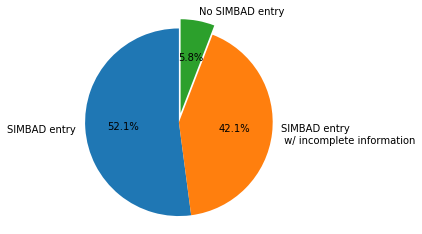

In [17]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'SIMBAD entry', 'SIMBAD entry \n w/ incomplete information', 'No SIMBAD entry'
sizes = [2593, 2094, 291]
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig('SIMBAD STATS')

## SpTs Comparison

In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [12]:
xlabels = []
for i in range (0,20):
    if i < 10:
        temp = 'K' + str(i)
        xlabels.append(temp)
    else:
        temp = 'M' + str(i-10)
        xlabels.append(temp)
xlabels.append('L0')

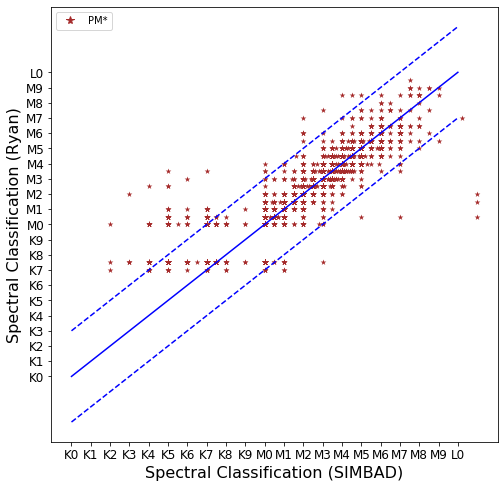

In [14]:
SPT = proc[proc['GROUP'].isna()]
SPT = SPT[['SIMBAD_SPT']]
SPT = SPT.merge(kast['LSPN_SPT'],left_index=True,right_index=True)
SPT = SPT.merge(proc['SIMBAD_SPT_MK'],left_index=True,right_index=True)
SPT['NSPT_SIMBAD'] = SPT['SIMBAD_SPT'].apply(lambda x: splat.typeToNum(x)) 
SPT['NSPT_LSPM'] = SPT['LSPN_SPT'].apply(lambda x: splat.typeToNum(x)) 
SPT = SPT[SPT['NSPT_SIMBAD']!=0]
a = SPT['NSPT_SIMBAD']
b = SPT['NSPT_LSPM']

plt.figure(figsize=[8,8])
plt.scatter(x = a, y = b, marker='*',c='brown',linewidths=0)
plt.plot([0,20], [0,20], color='blue')
plt.plot([0,20], [3,23], linestyle='dashed', color='blue')
plt.plot([0,20], [-3,17], linestyle='dashed', color='blue')
red_star =  mlines.Line2D([], [], color='brown', marker='*', linestyle='None',
                          markersize=8, label='PM*')
plt.legend(handles=[red_star])
plt.xlabel('Spectral Classification (SIMBAD)', fontsize=16)
plt.ylabel('Spectral Classification (Ryan)', fontsize=16)
plt.xticks(np.arange(0,21), xlabels, fontsize=12)
plt.yticks(np.arange(0,21), xlabels, fontsize=12)
plt.savefig('SPT COMPARISON')

## Distributions

### a) SpTs

In [15]:
xlabels = []
for i in range (0,20):
    if i < 10:
        temp = 'K' + str(i)
        xlabels.append(temp)
    else:
        temp = 'M' + str(i-10)
        xlabels.append(temp)
xlabels.append('L0')

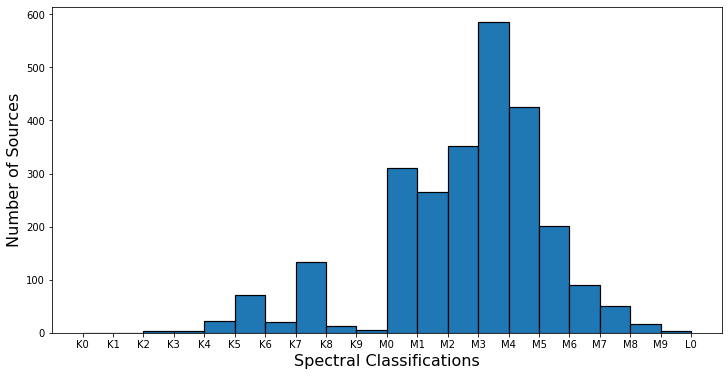

In [42]:
plt.figure(figsize=(12,6))
plt.hist(SPT['NSPT_SIMBAD'],bins=np.arange(0,21), edgecolor='black', linewidth=1.2)
plt.xticks(np.arange(0,21), xlabels)
plt.xlabel('Spectral Classifications', fontsize=16)
plt.ylabel('Number of Sources', fontsize=16)
plt.savefig('SPT STATS')

### b) Distances

In [18]:
DISTANCE = 1000/proc['SIMBAD_PLX']

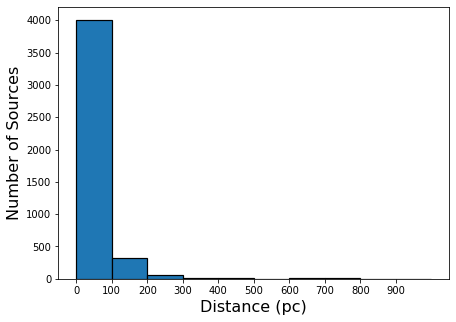

In [43]:
plt.figure(figsize=(7,5))
plt.hist(DISTANCE,bins=[0,100,200,300,400,500,600,700,800,900,1000],edgecolor='black', linewidth=1.2)
plt.xticks(np.arange(0,1000,100))
plt.xlabel('Distance (pc)', fontsize=16)
plt.ylabel('Number of Sources', fontsize=16)
plt.savefig('DISTANCE')

In [16]:
mean = DISTANCE.mean()
median = DISTANCE.median()
std = DISTANCE.std()

### c) Separation & Object Types

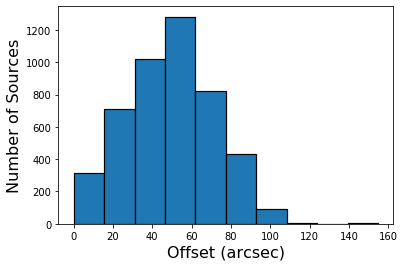

In [44]:
plt.hist(proc['SIMBAD_OFFSET'], edgecolor='black', linewidth=1.2)
plt.xlabel('Offset (arcsec)', fontsize=16)
plt.ylabel('Number of Sources', fontsize=16)
plt.savefig('OFFSET')

In [21]:
raw = pd.read_pickle('./seapickle_V1.pkl')

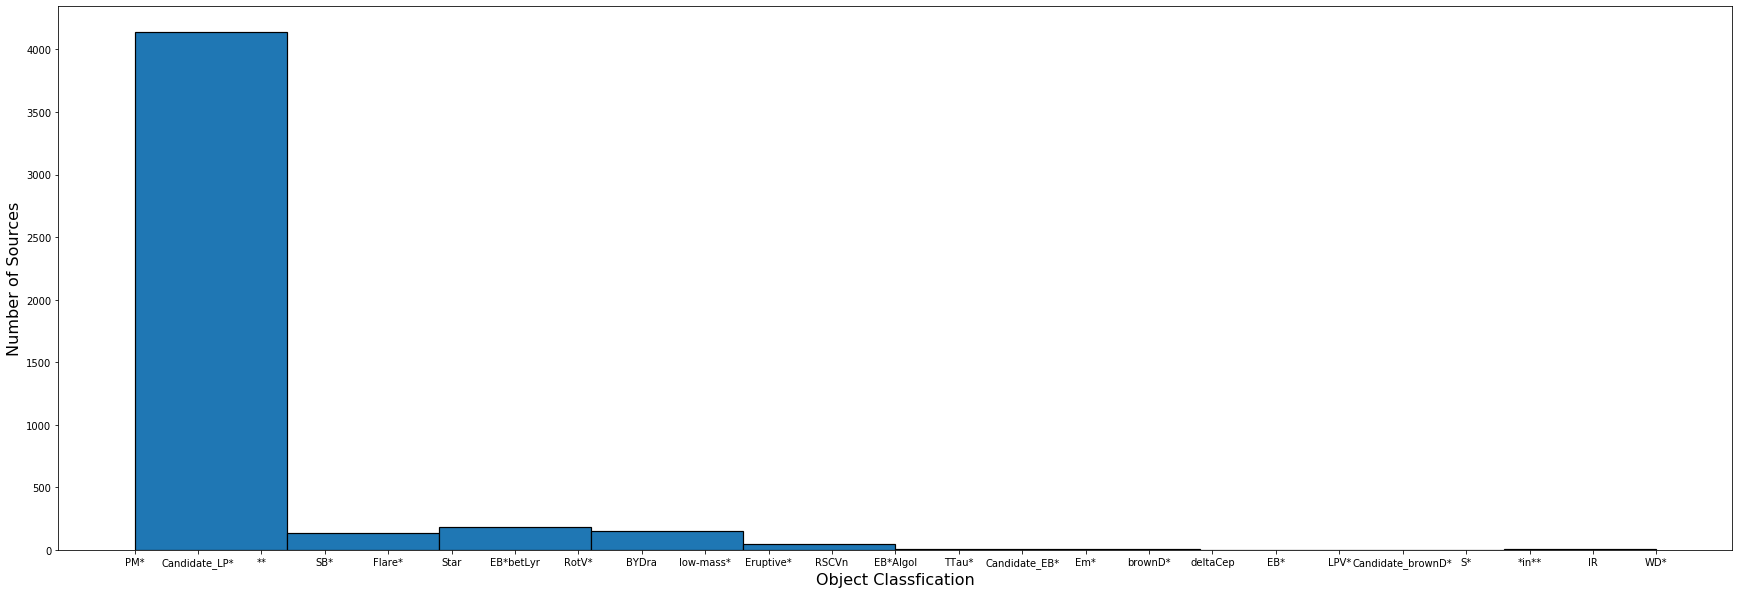

In [50]:
plt.figure(figsize=(30,10))
plt.hist(raw['OTYPE'].dropna(), edgecolor='black', linewidth=1.2)
plt.xlabel('Object Classfication', fontsize=16)
plt.ylabel('Number of Sources', fontsize=16)
plt.savefig('OTYPE')

In [38]:
patches

<a list of 10 Patch objects>


### d) Color magnitdue diagram

In [24]:
raw.columns

Index(['SIMBAD_MAIN_ID', 'SIMBAD_RA', 'SIMBAD_DEC', 'SIMBAD_COO_BIBCODE',
       'SIMBAD_OFFSET', 'SIMBAD_SPT_MK', 'SIMBAD_SPT_MK_BIBCODE', 'SIMBAD_SPT',
       'SIMBAD_SPT_BIBCODE', 'SIMBAD_PLX', 'SIMBAD_PLX_E',
       'SIMBAD_PLX_BIBCODE', 'SIMBAD_PMRA', 'SIMBAD_PMDEC', 'SIMBAD_PM_E_MAJ',
       'SIMBAD_PM_E_MIN', 'SIMBAD_PM_E_ANGLE', 'SIMBAD_PM_BIBCODE',
       'SIMBAD_RV_TYPE', 'SIMBAD_RV', 'SIMBAD_RV_E', 'SIMBAD_RV_BIBCODE',
       'SIMBAD_BIBCODES', 'SIMBAD_IDS', 'SIMBAD_UMAG', 'SIMBAD_UMAG_E',
       'SIMBAD_UMAG_SYSTEM', 'SIMBAD_UMAG_BIBCODE', 'SIMBAD_BMAG',
       'SIMBAD_BMAG_E', 'SIMBAD_BMAG_SYSTEM', 'SIMBAD_BMAG_BIBCODE',
       'SIMBAD_VMAG', 'SIMBAD_VMAG_E', 'SIMBAD_VMAG_SYSTEM',
       'SIMBAD_VMAG_BIBCODE', 'SIMBAD_GMAG', 'SIMBAD_GMAG_E',
       'SIMBAD_GMAG_SYSTEM', 'SIMBAD_GMAG_BIBCODE', 'SIMBAD_RMAG',
       'SIMBAD_RMAG_E', 'SIMBAD_RMAG_SYSTEM', 'SIMBAD_RMAG_BIBCODE',
       'SIMBAD_IMAG', 'SIMBAD_IMAG_ERR', 'SIMBAD_IMAG_SYSTEM',
       'SIMBAD_IMAG_BIBCODE', 'SIMBA

#### i) JHK

In [25]:
color = raw[raw['SIMBAD_JMAG'].notna()][['SIMBAD_JMAG','SIMBAD_HMAG','SIMBAD_KMAG','SIMBAD_PLX']].copy()
color.rename(columns=({'SIMBAD_JMAG':'J','SIMBAD_HMAG':'H','SIMBAD_KMAG':'K','SIMBAD_PLX':'PLX'}), inplace=True)

In [26]:
color['J_abs'] = color['J'] + 5 * (np.log10(color['PLX']) + 1)
color['H_abs'] = color['H'] + 5 * (np.log10(color['PLX']) + 1)
color['K_abs'] = color['K'] + 5 * (np.log10(color['PLX']) + 1)

In [27]:
color['J-K'] = color['J_abs'] - color['K_abs']
color['J-H'] = color['J_abs'] - color['H_abs']
color['H-K'] = color['H_abs'] - color['K_abs']

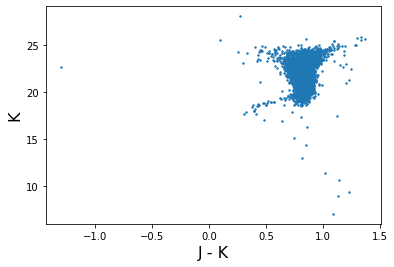

In [28]:
plt.scatter(x=color['J-K'], y=color['K_abs'], s=2)
plt.xlabel('J - K', fontsize=16)
plt.ylabel('K', fontsize=16)
plt.savefig('K J-K')

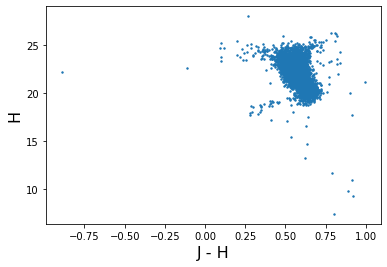

In [29]:
plt.scatter(x=color['J-H'], y=color['H_abs'], s=2)
plt.xlabel('J - H', fontsize=16)
plt.ylabel('H', fontsize=16)
plt.savefig('H J-H')

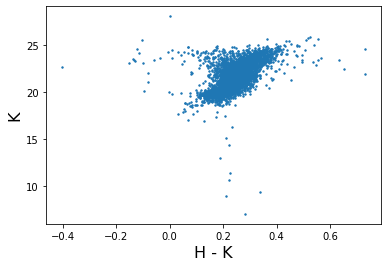

In [30]:
plt.scatter(x=color['H-K'], y=color['K_abs'], s=2)
plt.xlabel('H - K', fontsize=16)
plt.ylabel('K', fontsize=16)
plt.savefig('K H-K')

#### ii) BV

In [31]:
color = raw[raw['SIMBAD_VMAG'].notna() & raw['SIMBAD_BMAG'].notna()][['SIMBAD_BMAG','SIMBAD_VMAG','SIMBAD_PLX']].copy()
color.rename(columns=({'SIMBAD_BMAG':'B','SIMBAD_VMAG':'V','SIMBAD_PLX':'PLX'}), inplace=True)

In [32]:
color['B_abs'] = color['B'] + 5 * (np.log10(color['PLX']) + 1)
color['V_abs'] = color['V'] + 5 * (np.log10(color['PLX']) + 1)
color['B-V'] = color['B_abs'] - color['V_abs']

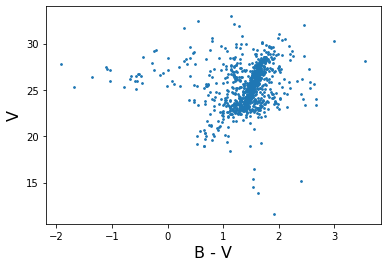

In [33]:
plt.scatter(x=color['B-V'], y=color['V_abs'],s=3)
plt.xlabel('B - V', fontsize=16)
plt.ylabel('V', fontsize=16)
plt.savefig('V B-V')

# KAST

In [7]:
kast = pd.read_csv('./kast_spectra_calculations_20200823.csv')

In [8]:
kast['COORD'] = kast['RA'] + ' ' + kast['DEC']
kast['SKYCOORD'] = kast['COORD'].apply(lambda x: splat.properCoordinates(x))

In [10]:
def query_ryan(length=25):
    t1 = process_time()
    raw_result = customSimbad.query_region(splat.properCoordinates(kast['COORD'][0]), radius = 1*u.arcmin).to_pandas()
    for i in range(1, length):
        try:
            temp = customSimbad.query_region(splat.properCoordinates(kast['COORD'][i]), radius = 1*u.arcmin).to_pandas()
            temp = s_filter(o_filter(temp))
            temp = compare_spt(temp,i)
            #temp = take_favorite(temp)
            #temp = magnet_V(temp)
            raw_result = raw_result.append(temp.iloc[0])
        except:
            raw_result = raw_result.append(pd.Series(dtype='str'), ignore_index=True)
    t2 = process_time()
    raw_result.reset_index(inplace=True)
    raw_result.drop('index', axis=1, inplace=True)
    # For some reason SIMBAD returns some columns twice. Below I manually dropped those.
    raw_result = raw_result.drop(columns=['RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA',
       'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH','MK_ds', 'MK_mss','SP_QUAL','RA_2','DEC_2','COO_BIBCODE_2','SP_BIBCODE_2'], axis=0)
    raw_result['FLAG'] = ''
    print(str((t2-t1)/60) + ' mins')
    return raw_result

def compare_spt(df, index, diff=3):
    temp = df[df['SP_TYPE'].str.decode('ascii').apply(lambda x: abs(splat.typeToNum(x) - splat.typeToNum(kast['spt'][index]))) <= diff].copy()
    if len(temp) == 0:
        return df
    else:
        return temp

def diff_spt(df, verbose=False):
    df['diff_mk'] = abs(raw['MK_Spectral_type'].str.decode('ascii').apply(lambda x: splat.typeToNum(x)) - kast['spt'].apply(lambda x: splat.typeToNum(x)))
    df['diff_simbad'] = abs(raw['SP_TYPE'].str.decode('ascii').apply(lambda x: splat.typeToNum(x)) - kast['spt'].apply(lambda x: splat.typeToNum(x)))
    df['DIFF_SPT'] = df[['diff_mk','diff_simbad']].min(axis=1)
    if verbose:
        return df
    else:
        df.drop(columns=['diff_mk','diff_simbad'], axis=0, inplace=True)
        return df

In [11]:
raw = query_ryan(len(kast))

0.4278645833333333 mins


In [12]:
diff_spt(raw, False)

,MAIN_ID,RA,DEC,COO_BIBCODE,DISTANCE_RESULT,MK_Spectral_type,MK_bibcode,SP_TYPE,SP_BIBCODE,PLX_VALUE,...,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,OTYPE,FLAG,DIFF_SPT
0,b'G 202-60',16 34 25.3540,+47 50 28.351,b'2018yCat.1345....0G',3.581848,b'M4.5Ve',2003AJ....126.3007R,b'M4.5Ve',b'2003AJ....126.3007R',39.9035,...,0.019,b'Vega',b'2003yCat.2246....0C',9.862,0.014,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.5
1,b'DENIS J162601.3-063926',16 26 01.3376,-06 39 26.074,b'2018yCat.1345....0G',5.030805,b'',,b'',b'',43.9336,...,0.023,b'Vega',b'2003yCat.2246....0C',11.846,0.024,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN
2,b'LP 271-25',14 28 43.2272,+33 10 39.245,b'2018yCat.1345....0G',2.863849,b'M9.1V',2014ApJ...794..143B,b'M9Ve',b'2005PASP..117..676R',90.9962,...,0.029,b'Vega',b'2003yCat.2246....0C',10.744,0.024,b'Vega',b'2003yCat.2246....0C',b'low-mass*',,0.9
3,b'2MASS J16154245+0546400',16 15 42.4562,+05 46 40.065,b'2018yCat.1345....0G',8.373846,b'M9',2008AJ....136.1290R,b'M9',b'2007AJ....133.2258S',56.0884,...,0.030,b'Vega',b'2003yCat.2246....0C',11.741,0.022,b'Vega',b'2003yCat.2246....0C',b'low-mass*',,1.0
4,b'LP 791-18',11 02 45.9543,-16 24 22.285,b'2018yCat.1345....0G',0.715823,b'',,b'',b'',37.7177,...,0.022,b'Vega',b'2003yCat.2246....0C',10.644,0.023,b'Vega',b'2003yCat.2246....0C',b'Star',,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,b'WISEA J053926.39+471254.3',05 39 26.3686,+47 12 56.476,b'2018yCat.1345....0G',3.786043,b'',,b'',b'',37.5649,...,0.031,b'Vega',b'2003yCat.2246....0C',11.956,0.023,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN
252,b'SDSS J081506.29+652158.4',08 15 06.3261,+65 21 58.752,b'2018yCat.1345....0G',2.173365,b'',,b'',b'',26.4456,...,NaN,b'',b'',NaN,NaN,b'',b'',b'Candidate_brownD*',,NaN
253,b'G 226-38',16 55 17.4680,+62 24 45.653,b'2018yCat.1345....0G',3.752364,b'',,b'',b'',25.1326,...,0.026,b'Vega',b'2003yCat.2246....0C',9.432,0.020,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN
254,b'2MASS J14573061+1102015',14 57 30.6078,+11 02 01.566,b'2018yCat.1345....0G',5.801834,b'',,b'',b'',19.9070,...,0.027,b'Vega',b'2003yCat.2246....0C',11.641,0.024,b'Vega',b'2003yCat.2246....0C',b'PM*',,NaN


In [13]:
raw[raw['DIFF_SPT'].notna()]

,MAIN_ID,RA,DEC,COO_BIBCODE,DISTANCE_RESULT,MK_Spectral_type,MK_bibcode,SP_TYPE,SP_BIBCODE,PLX_VALUE,...,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,OTYPE,FLAG,DIFF_SPT
0,b'G 202-60',16 34 25.3540,+47 50 28.351,b'2018yCat.1345....0G',3.581848,b'M4.5Ve',2003AJ....126.3007R,b'M4.5Ve',b'2003AJ....126.3007R',39.9035,...,0.019,b'Vega',b'2003yCat.2246....0C',9.862,0.014,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.5
2,b'LP 271-25',14 28 43.2272,+33 10 39.245,b'2018yCat.1345....0G',2.863849,b'M9.1V',2014ApJ...794..143B,b'M9Ve',b'2005PASP..117..676R',90.9962,...,0.029,b'Vega',b'2003yCat.2246....0C',10.744,0.024,b'Vega',b'2003yCat.2246....0C',b'low-mass*',,0.9
3,b'2MASS J16154245+0546400',16 15 42.4562,+05 46 40.065,b'2018yCat.1345....0G',8.373846,b'M9',2008AJ....136.1290R,b'M9',b'2007AJ....133.2258S',56.0884,...,0.030,b'Vega',b'2003yCat.2246....0C',11.741,0.022,b'Vega',b'2003yCat.2246....0C',b'low-mass*',,1.0
8,b'LP 370-26',09 29 11.0784,+25 58 09.277,b'2018yCat.1345....0G',1.658604,b'M5.0',2005A&A...442..211S,b'M5.0',b'2008MNRAS.384..150L',56.7136,...,0.023,b'Vega',b'2003yCat.2246....0C',9.958,0.018,b'Vega',b'2003yCat.2246....0C',b'PM*',,1.0
10,b'LP 606-35',09 02 06.9104,+00 33 19.437,b'2018yCat.1345....0G',1.413396,b'M6.5',1993ApJ...406..701K,b'M6V',b'1991ApJS...77..417K',46.0133,...,0.023,b'Vega',b'2003yCat.2246....0C',11.161,0.021,b'Vega',b'2003yCat.2246....0C',b'low-mass*',,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,b'NLTT 29567',12 05 36.3649,+56 23 45.439,b'2018yCat.1345....0G',3.061821,b'M5V',2014AJ....147...20N,b'M5V',b'2014AJ....147...20N',49.9263,...,0.023,b'Vega',b'2003yCat.2246....0C',9.847,0.019,b'Vega',b'2003yCat.2246....0C',b'PM*',,0.0
242,b'LSPM J0746+2000',07 46 42.4953,+20 00 32.612,b'2003AJ....125..984M',7.139007,b'L0.5',2011ApJS..197...19K,b'L0+L1.5',b'2017ApJS..231...15D',80.9000,...,0.022,b'Vega',b'2003yCat.2246....0C',10.468,0.022,b'Vega',b'2003yCat.2246....0C',b'brownD*',,8.5
243,b'CTI 170958.5+275905',17 10 28.2848,+27 58 09.846,b'2018yCat.1345....0G',3.867914,b'M5.5V',1994ApJS...94..749K,b'M5.5V',b'1994ApJS...94..749K',42.7861,...,0.022,b'Vega',b'2003yCat.2246....0C',10.939,0.018,b'Vega',b'2003yCat.2246....0C',b'PM*',,1.5
245,b'LP 401-10',22 54 11.1784,+25 27 56.618,b'2018yCat.1345....0G',2.446647,b'M5.5e',2002AJ....123.2828C,b'M5.5Ve',b'2003AJ....126.3007R',43.1294,...,0.022,b'Vega',b'2003yCat.2246....0C',10.685,0.017,b'Vega',b'2003yCat.2246....0C',b'PM*',,1.5


In [14]:
# rename the columns
ionames = pd.read_excel('./Catalogs and columns.xlsx')
ionames = ionames[ionames['output name'] != '[drop]'].dropna(how='all') # obtain the input name vs output name
new_names = ionames[['input name','output name']].set_index('input name')['output name'].to_dict() # turn the input vs output name into a dictionary for the next step
raw.rename(columns=new_names, inplace=True)

# identify columns that goes like b'xxx'
columns_to_convert = []
for i in raw.columns:
    if 'b' in str(raw.loc[213, i]): # Manually located 213 b/c that's where one of the new results is and it has byte type entries.
        columns_to_convert.append(i)
        
# decode the 'bytes' to 'string'
for index in raw.index:
    raw.loc[index, columns_to_convert] = raw.loc[index, columns_to_convert].str.decode('ascii')

In [15]:
raw.loc[raw[raw['DIFF_SPT'] > 3].index, 'FLAG'] = '>3'

In [16]:
raw['GROUP'] = np.nan


In [17]:
raw.loc[raw[raw['SIMBAD_SPT'] == ''].index, 'GROUP'] = 'NO SIMBAD SPT'

In [18]:
proc = pd.merge(kast, raw, left_index=True, right_index=True, how='outer')

In [23]:
proc.to_excel('./kast_catalogV2.xlsx')

In [22]:
proc[proc['FLAG'] == '>3']

,name,filename,tags,RA,DEC,OBSDATE,spt,subtype,spt_chi2,spt_scale,...,SIMBAD_HMAG_SYSTEM,SIMBAD_HMAG_BIBCODE,SIMBAD_KMAG,SIMBAD_KMAG_ERR,SIMBAD_KMAG_SYSTEM,SIMBAD_KMAG_BIBCODE,OTYPE,FLAG,DIFF_SPT,GROUP
13,1735+2634,kastRED_J1735+2634B_20170813.fits,"OO, S/N, !",17:35:13,26:34:46,2017-08-13T05:02:20.76,M0.0,0.0,347132.493200,5.180000e-16,...,Vega,2003yCat.2246....0C,10.157,0.020,Vega,2003yCat.2246....0C,low-mass*,>3,7.0,NaN
21,2254+2527,kastRED_J2254+2527B_20180622.fits,"S/N, NO",22:54:11,25:27:57,2018-06-22T10:58:32.19,esdK7.0,-3.0,181743.883700,5.810000e-17,...,Vega,2003yCat.2246....0C,10.685,0.017,Vega,2003yCat.2246....0C,PM*,>3,8.5,NaN
26,J2352-1100,kastRED_J2352-1100B_20190918.fits,"S/N, NO",23:52:05,-11:00:44,2019-09-18T08:27:23.12,M0.0,0.0,9699.560938,1.330000e-16,...,Vega,2003yCat.2246....0C,11.742,0.020,Vega,2003yCat.2246....0C,low-mass*,>3,7.0,NaN
53,J1448+1554,kastRED_J1448+1554B_20180717.fits,"S/N, OO",14:48:03,15:54:15,2018-07-18T05:43:47.93,M0.0,0.0,327213.250200,2.210000e-16,...,Vega,2003yCat.2246....0C,11.475,0.020,Vega,2003yCat.2246....0C,PM*,>3,6.5,NaN
128,J1314+6622,kastRED_J1314+6622C_20200205.fits,"S/N, NO",13:14:24,66:22:33,2020-02-06T11:08:36.76,M0.0,0.0,76425.515700,1.390000e-15,...,Vega,2003yCat.2246....0C,10.508,0.017,Vega,2003yCat.2246....0C,PM*,>3,5.5,NaN
135,J0815+1030,kastRED_J0815+1030B_20200203.fits,"S/N, NO",8:15:14,10:30:13,2020-02-04T06:29:03.88,M0.0,0.0,15959.472420,2.510000e-16,...,Vega,2003yCat.2246....0C,11.334,0.023,Vega,2003yCat.2246....0C,low-mass*,>3,7.0,NaN
173,J1314+6622,kastRED_J1314+6622B_20200205.fits,"S/N, NO",13:14:24,66:22:33,2020-02-06T11:08:36.76,M0.0,0.0,639602.677900,8.340000e-16,...,Vega,2003yCat.2246....0C,10.508,0.017,Vega,2003yCat.2246....0C,PM*,>3,5.5,NaN
238,J1115+5657,kastRED_J1115+5657_20200206.fits,None,11:11:55,56:57:30,2020-02-07T12:25:53.26,M7.0,7.0,48391.727780,5.830000e-15,...,Vega,2003yCat.2246....0C,11.444,0.021,Vega,2003yCat.2246....0C,PM*,>3,5.0,NaN
242,J0746+2000,kastRED_J0746+2000B_20200311.fits,"lto, S/N, ?",7:46:43,20:00:32,2020-03-12T05:23:36.30,M2.0,2.0,7372.281033,2.410000e-16,...,Vega,2003yCat.2246....0C,10.468,0.022,Vega,2003yCat.2246....0C,brownD*,>3,8.5,NaN


In [6]:
# WIP

In [12]:
random = splat.getSpectrum(spt='M6')[0]


Retrieving 60 files



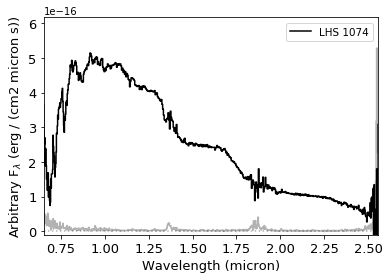

[<Figure size 432x288 with 1 Axes>]

In [14]:
random.plot()